In [168]:
import torch
import torchvision
import matplotlib.pyplot as plt
import os
from PIL import Image
import json
import torch
import pathlib
from pathlib import Path
import PixelEncoder
from typing import Tuple, Dict, List
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import math
from math import sqrt

In [169]:
data_path = Path(
    f"/Users/mary/Documents/School/Sketch Simplification/Sketch-Simplification/dataset"
)

In [173]:
class SketchData(torch.utils.data.Dataset):
    """
    Custom PyTorch dataset for image and JSON pairs.

    Args:
        root_dir (str): Path to the root directory containing image folders.
        transform (callable, optional): A function/transform to apply to the image.
    """

    def __init__(self, targ_dir, transform=None):
        self.paths = list(targ_dir.glob("*/."))

        self.steps = len(os.listdir(self.paths[0] / Path("offsets")))
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        img = self.load_timestep_img(index, 5)
        if self.transform:
            return self.transform(img)  # return data, label (X, y)
        else:
            return img

    def load_image(self, index: int) -> Image.Image:
        data_path = self.paths[index]

        return Image.open(data_path / Path("base.png"))

    def load_timestep_img(self, index, t):
        img = self.load_image(index).convert("L")
        width, height = img.size
        img_array = np.array(img)
        flat_array = img_array.flatten()

        offsetsPath = self.paths[index] / Path(f"offsets/offset_{index}.json")
        offsets = json.load(offsetsPath)

        # turn image into points and apply offsets, then turn it back into pixels
        flat_array = PixelEncoder()
        flat_array += offsets
        flat_array.reshape(width, height)
        return

In [174]:
# Global params

data = SketchData(targ_dir=data_path)

T = data.steps

BATCH_SIZE = 1

In [175]:
def show_images(datset, num_samples=20, cols=4):
    """Plots some samples from the dataset"""
    plt.figure(figsize=(15, 15))
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples / cols) + 1, cols, i + 1)
        plt.imshow(img)


show_images(data)

AttributeError: 'PosixPath' object has no attribute 'read'

<Figure size 1500x1500 with 0 Axes>

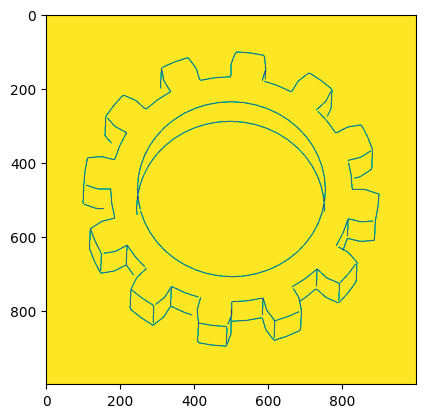

In [128]:
# Transform data

IMG_SIZE = 10, 10


def load_transformed_dataset():
    # data_transforms = transforms.Compose(
    #     [
    #         transforms.Resize((IMG_SIZE, IMG_SIZE)),
    #         transforms.RandomHorizontalFlip(),
    #         transforms.ToTensor(),  # Scales data into [0,1]
    #         transforms.Lambda(lambda t: (t * 2) - 1),  # Scale between [-1, 1]
    #     ]
    # )

    data_transforms = transforms.Compose(
        [
            # transforms.Resize((64, 64)),
            # transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            # transforms.Lambda(lambda t: (t / 64)),
        ]
    )
    data_transform = transforms.Compose(data_transforms)

    train = SketchData(data_path, transform=data_transforms)

    # TODO make data split so that we aren't using duplicate data
    test = SketchData(data_path, transform=data_transforms)
    return torch.utils.data.ConcatDataset([train, test])


def show_tensor_image(image):
    reverse_transforms = transforms.Compose(
        [
            # transforms.Lambda(lambda t: (t + 1) / 2),
            # transforms.Lambda(lambda t: t.permute(1, 2, 0)),  # CHW to HWC
            # transforms.Lambda(lambda t: t * 255.0),
            # transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
            transforms.ToPILImage(),
        ]
    )

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))


data = load_transformed_dataset()
show_tensor_image(data[0])

Shape =  torch.Size([1, 1, 1000, 1000])
(tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,

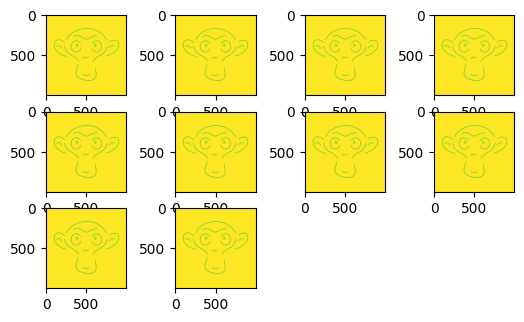

In [166]:
def forward_diffusion_sample(x_0, t, device="cpu"):
    # print(x_0)
    # _, _, width, height = x_0.shape
    # print("Shape = ", x_0.shape)
    # points = PixelEncoder.pixelToPoint(x_0[0, 0, :, :], width, height)
    # print(points)
    # print(points)
    # offsets = PixelEncoder.bakeOffsets(x_0, t)
    # points += offsets
    return x_0, x_0


num_images = 1

# print(data[0])
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)


image = next(iter(dataloader))

for idx in range(0, T):
    t = torch.Tensor([idx]).type(torch.int64)

    plt.subplot(int(sqrt(T)) + 1, int(sqrt(T)) + 1, idx + 1)
    # plt.axis(False)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

plt.show()